In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

def get_windows(ts, beg, end, wsize, target_period):
    windows = []
    targets = []
    
    beg = beg + wsize
    for i in range(beg, end):
        indicies = range(i-wsize, i)
        windows.append(np.reshape(ts[indicies], (wsize, 1)))
        targets.append(ts[i + target_period])
    return np.array(windows), np.array(targets)

def plotwindow(data, pred, ax=None):
    plt.plot(data[1], label="Target", marker='o',linestyle='None')
    if pred:
        plt.plot(pred, label="Prediction", marker='x', linestyle='None')
    t = list(range(-data[0].shape[0], 0))
    plt.plot(t, data[0].flatten(), label="History", marker='.')
    plt.xlim(t[0], 5)
    plt.legend()
    return plt

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size = input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features = hidden_size, out_features=num_classes)

        
    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        h_n = h_n.view(-1, self.hidden_size)
        x = self.linear(h_n)
        return x

def get_model(norm_y, window_size):
    
    TRAINSPLIT = int(0.6*len(y))
    
    target_period = 0

    train_windows, train_targets = get_windows(norm_y, 0, len(y), window_size,     target_period)

    
    train_windows_tensor = torch.Tensor(train_windows)
    train_targets_tensor = torch.Tensor(train_targets)
    train_data = torch.utils.data.TensorDataset(train_windows_tensor, train_targets_tensor)
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=5,shuffle=True)
    
    input_size = 1
    hidden_size = 8
    num_layers = 1
    num_classes = 1

    model = Net(input_size, hidden_size, num_classes, num_layers)
    
    epochs = 10
    learning_rate = 0.01

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_values = []
    for epoch in range(epochs):
        for data in dataloader:
            w, t = data
            outputs = model(w)
            optimizer.zero_grad()
            loss = criterion(outputs, t)
            loss.backward()
            optimizer.step()

            loss_values.append(loss.item())

    print('Finished Training')
    #plt.plot(loss_values) #loss function values
    #plt.show()
    
    return model
    
    

In [2]:
def lstm_predict(y, num_predicts=1):
    scaler = MinMaxScaler()
    norm_y = scaler.fit_transform(y.reshape(-1, 1))
    window_size = 10
    model = get_model(norm_y, window_size)
    norm_predictions = []
    predictions = []
    
    for i in range(num_predicts):
        #data = torch.Tensor([norm_y[window_size:]])
        #print([np.concatenate((norm_y, norm_predictions), axis=None)[window_size:]])
        data = torch.FloatTensor([np.concatenate((norm_y, norm_predictions), axis=None)[-window_size:].reshape(-1, 1)])
        prediction = model(data)
        prediction_value = prediction.item()
        norm_predictions.append(prediction_value)
        unscaled_prediction = scaler.inverse_transform(np.array(prediction_value).reshape(1, -1))
        predictions.extend(unscaled_prediction)
    return predictions
    

In [88]:
plt.rcParams["figure.figsize"] = (20,10)
def visualise(y, predict_data, window_size, TRAINSPLIT):
    plt.plot(range(len(y), len(y) + window_size), predict_data, label="Prediction")
    plt.plot(y, label="Actual")
    plt.axvline(TRAINSPLIT, linestyle='--', label="Training split")
    plt.legend()
    plt.show()

Finished Training
[array([-0.50071905]), array([-0.54594123]), array([-0.57989919]), array([-0.59778037]), array([-0.60459546]), array([-0.6014794]), array([-0.58911718]), array([-0.57139781]), array([-0.54550229]), array([-0.51232731]), array([-0.47375108]), array([-0.43003291]), array([-0.38103826]), array([-0.32686317]), array([-0.2674574]), array([-0.20288029]), array([-0.13327297]), array([-0.05892226]), array([0.01960516]), array([0.10151286]), array([0.18562893]), array([0.27037963]), array([0.35388477]), array([0.43409564]), array([0.50898802]), array([0.57679062]), array([0.63618112]), array([0.6864046]), array([0.72728518]), array([0.75914219]), array([0.78265099]), array([0.79869053]), array([0.8082093]), array([0.81213299]), array([0.81130614]), array([0.80646425]), array([0.79822815]), array([0.78710618]), array([0.77350834]), array([0.75775865])]


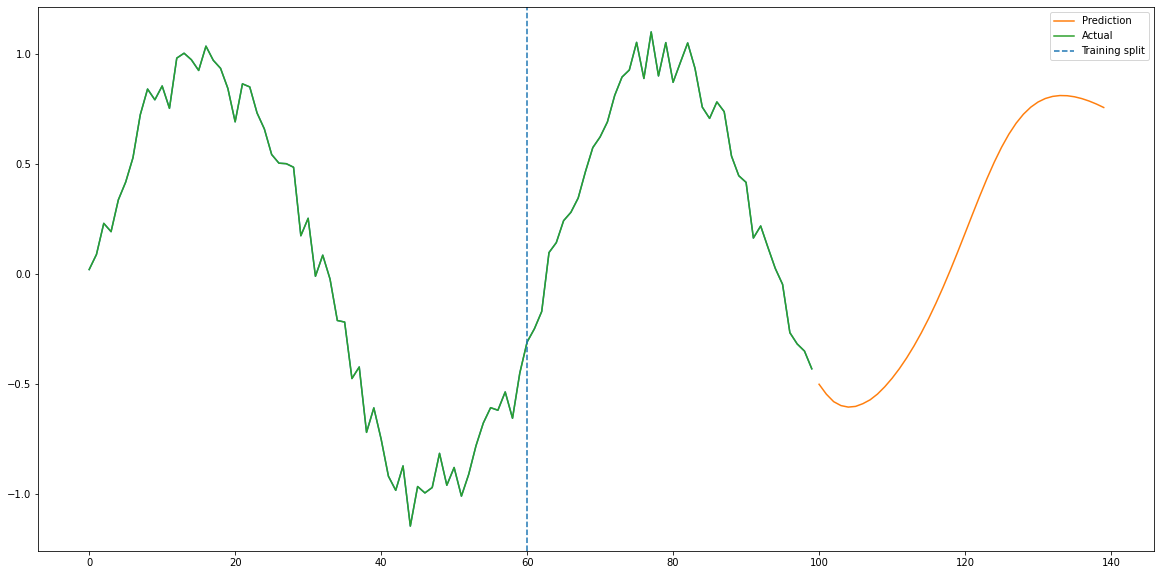

In [99]:
x = np.arange(0,10, 0.1)
y = np.sin(x) + np.random.normal(scale=0.08, size=len(x))
plt.plot(y)
num_predicts = 40
predicted_values = lstm_predict(y, num_predicts)
print(predicted_values)
visualise(y, predicted_values, num_predicts, int(0.6*len(y)))

Finished Training
[array([35.90813604]), array([36.07195365]), array([36.23394657]), array([36.39226025]), array([36.54603776]), array([36.69488264]), array([36.83857743]), array([36.97714773]), array([37.11061912]), array([37.23909817]), array([37.36250814]), array([37.48106647]), array([37.59482858]), array([37.70389679]), array([37.80837342]), array([37.90836931]), array([38.00400383]), array([38.09540063]), array([38.18268333]), array([38.26597132]), array([38.34540527]), array([38.42110883]), array([38.4932099]), array([38.56184489]), array([38.62714598]), array([38.68923254]), array([38.74823672]), array([38.80428643]), array([38.85750104]), array([38.90800419]), array([38.95591098]), array([39.00133653]), array([39.04439594]), array([39.08519579]), array([39.12384268]), array([39.16043465]), array([39.19507829]), array([39.22785034]), array([39.25886165]), array([39.28818894])]


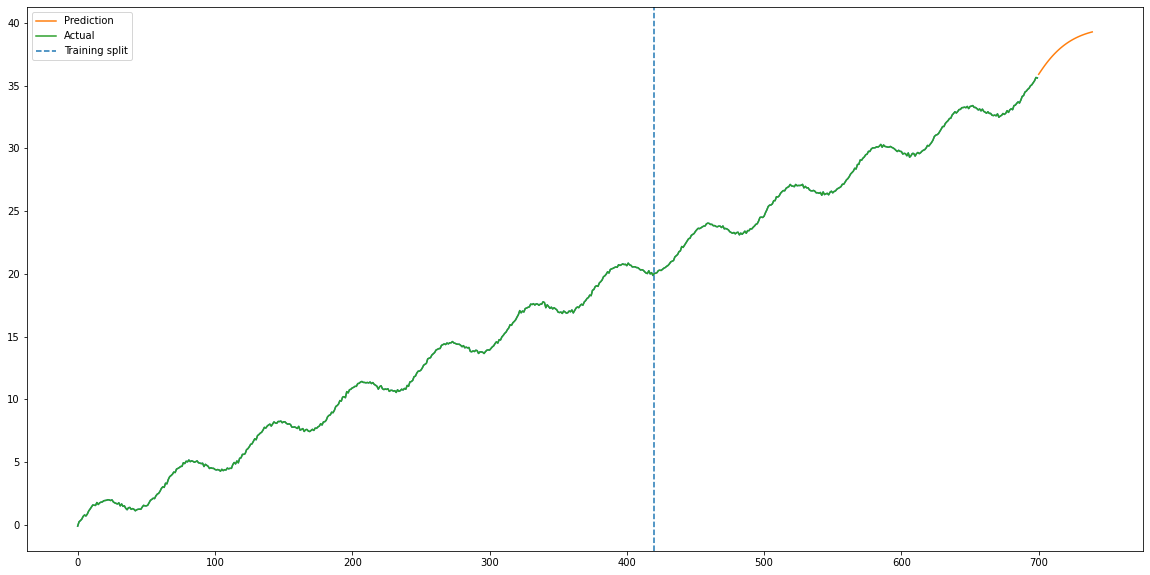

In [92]:
x = np.arange(0,70, 0.1)
y = np.sin(x) + np.random.normal(scale=0.08, size=len(x)) + 0.5*x
plt.plot(y)
num_predicts = 40
predicted_values = lstm_predict(y, num_predicts)
print(predicted_values)
visualise(y, predicted_values, num_predicts, int(0.6*len(y)))

Finished Training


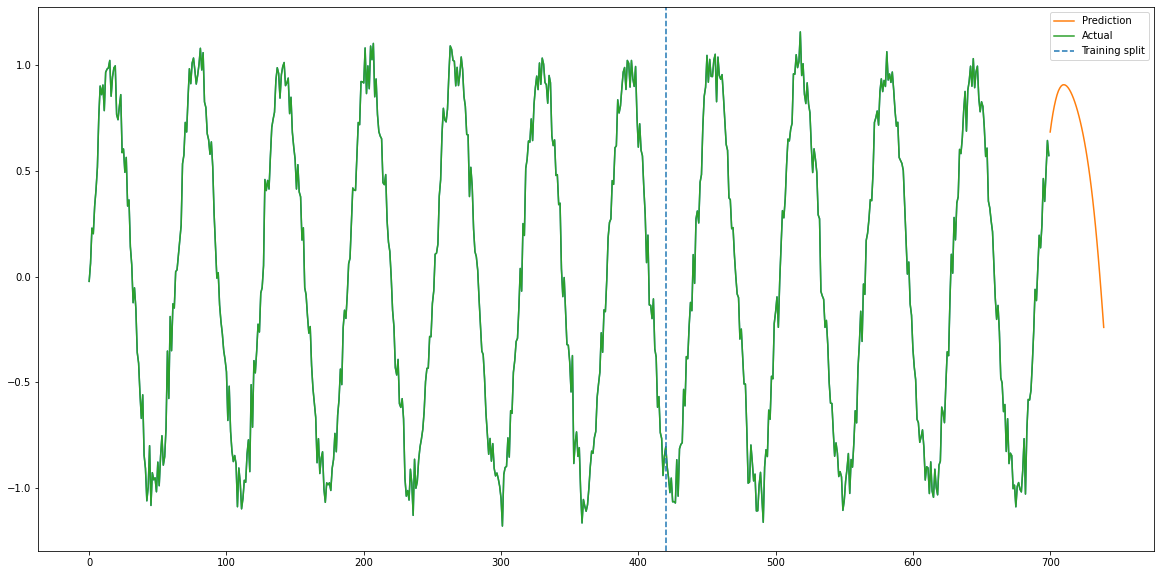

In [107]:
x = np.arange(0,70, 0.1)
y = np.sin(x) + np.random.normal(scale=0.08, size=len(x))
plt.plot(y)
num_predicts = 40
predicted_values = lstm_predict(y, num_predicts)
#print(predicted_values)
visualise(y, predicted_values, num_predicts, int(0.6*len(y)))

Finished Training


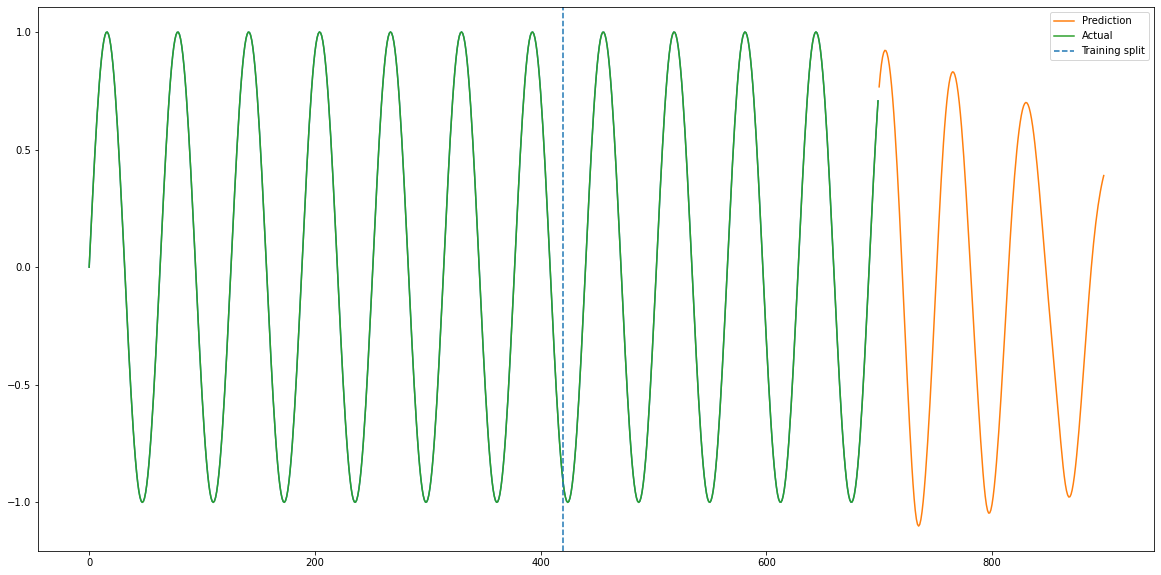

In [102]:
x = np.arange(0,70, 0.1)
y = np.sin(x)
plt.plot(y)
num_predicts = 200
predicted_values = lstm_predict(y, num_predicts)
#print(predicted_values)
visualise(y, predicted_values, num_predicts, int(0.6*len(y)))

Finished Training


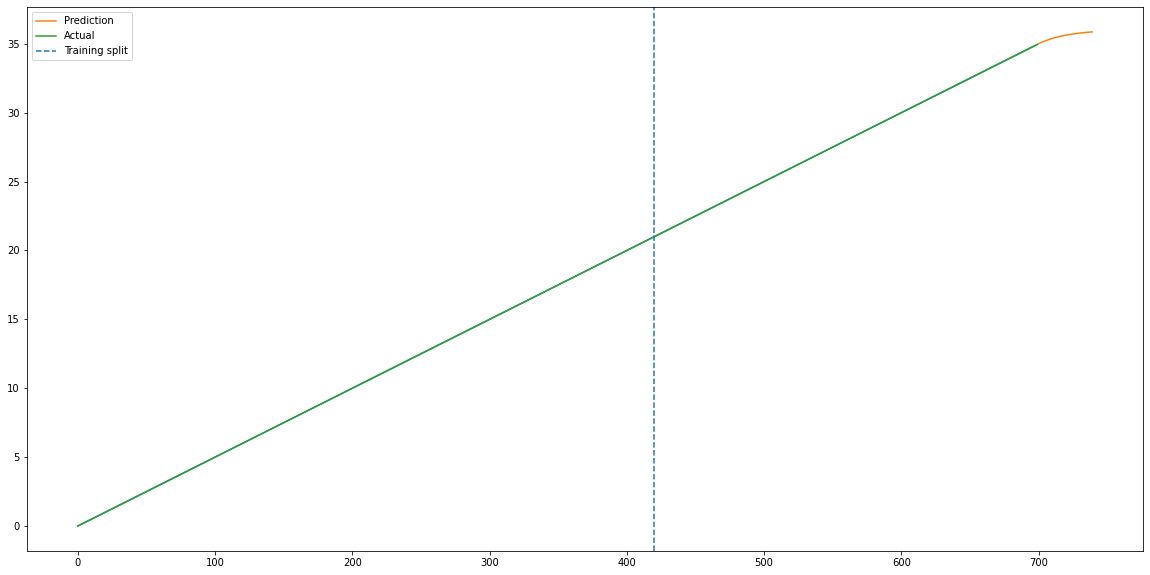

In [120]:
x = np.arange(0,70, 0.1)
y = 0.5*x
plt.plot(y)
num_predicts = 40
predicted_values = lstm_predict(y, num_predicts)
#print(predicted_values)
visualise(y, predicted_values, num_predicts, int(0.6*len(y)))

In [22]:
def lstm_predict1(y, num_predicts=1):
    scaler = MinMaxScaler()
    norm_y = scaler.fit_transform(y.reshape(-1, 1))
    window_size = 10
    model = get_model(norm_y, window_size)
    norm_predictions = []
    predictions = []
    w = norm_y[-window_size:]
    
    for i in range(num_predicts):
        data = torch.Tensor([w])
        prediction = model(data)
        prediction_value = prediction.item()
        norm_predictions.append(prediction_value)
        unscaled_prediction = scaler.inverse_transform(np.array(prediction_value).reshape(1, -1))
        predictions.extend(unscaled_prediction)
        w = np.roll(w, -1)
        w[window_size-1] = prediction_value
    return predictions
    

Finished Training


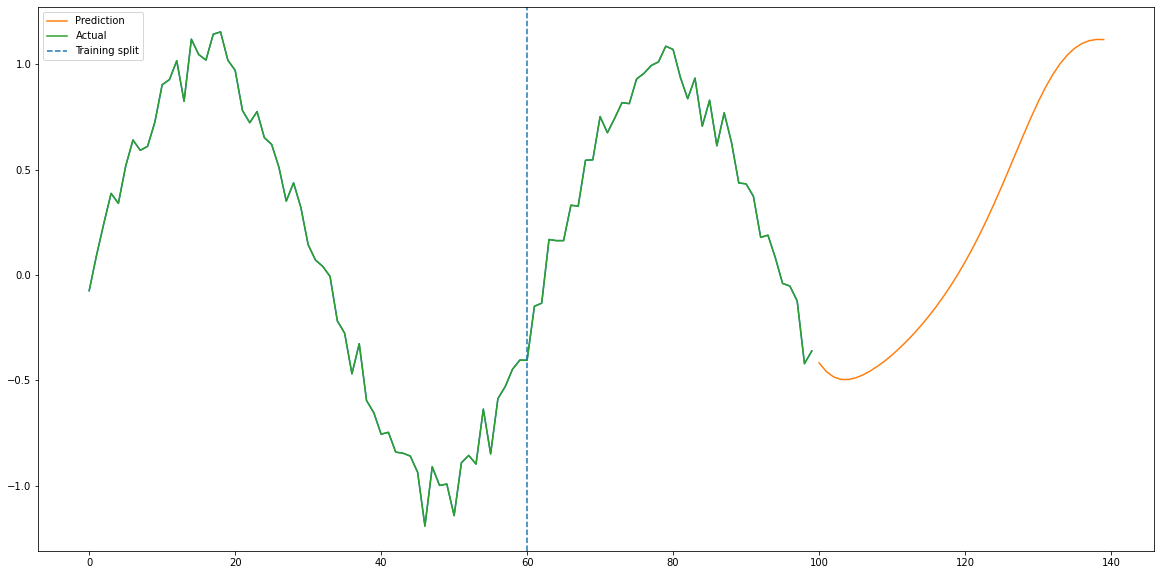

In [118]:
x = np.arange(0,10, 0.1)
y = np.sin(x) + np.random.normal(scale=0.08, size=len(x))
plt.plot(y)
num_predicts = 40
predicted_values = lstm_predict1(y, num_predicts)
visualise(y, predicted_values, num_predicts, int(0.6*len(y)))